## 2nd Project | Trading

###  Instructions
- Follow a Python Project structure.
- Work with a training and validation dataset to optimize & test your trading strategies using the datasets provided in the introduction section.
- Select n technical indicators (one for each team member).
- For each timeframe train/test files (1d, 1h, 5m, 1m):
    - Define buy/sell signals for each indicator.
    - Create all possible combinations of all technical indicators (2^n - 1).
    - Backtest the strategies while keeping track of the operations and cash/portfolio value time series, remember that we'll be opening long & short positions.
    - Optimize all technical indicator's parameters (TPE, Grid Search, PSO, Genetic Algorithms, ...), stop-loss/take-profit, volume of the trade, maximizing the profit of the strategy with the training dataset, consider the bounds of each variable!
    - Select the optimal strategy and describe it thoroughly (what indicators are used, when is the trade signal produced, etc.).
    - Now, use the optimal strategy with the test dataset and compare it to a passive strategy.


-------

In [1]:
from technical_analysis import Operation, TradingStrategy

show example of available all indicators

In [2]:
strategy = TradingStrategy('5m')

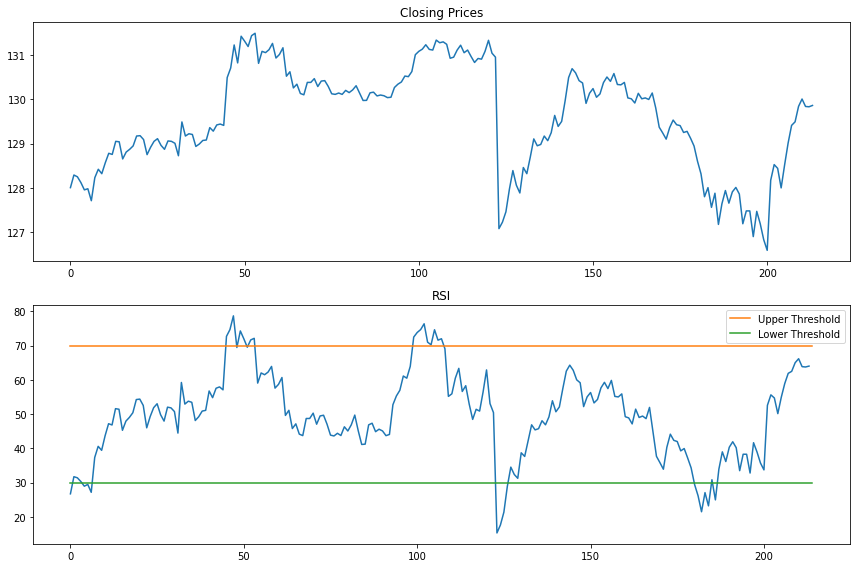

In [3]:
strategy.show_RSI()

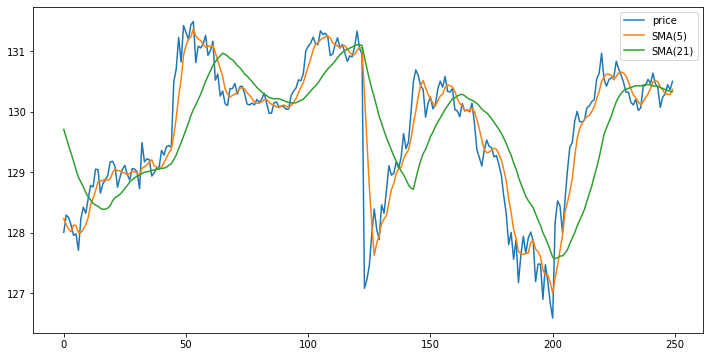

In [4]:
strategy.show_SMAs()

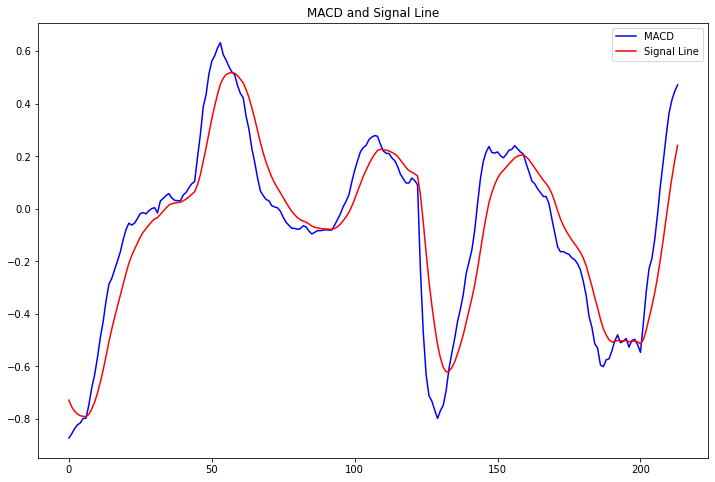

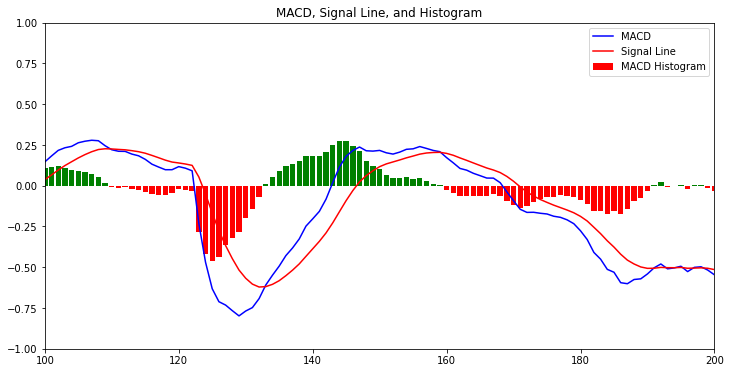

In [5]:
strategy.show_MACD()

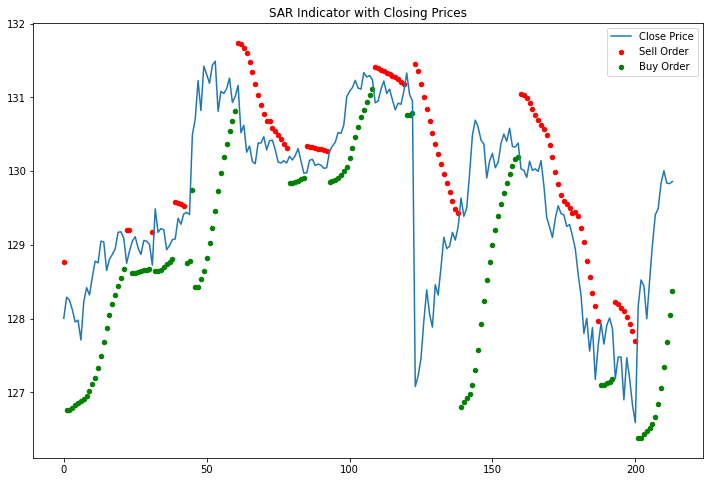

In [6]:
strategy.show_SAR()

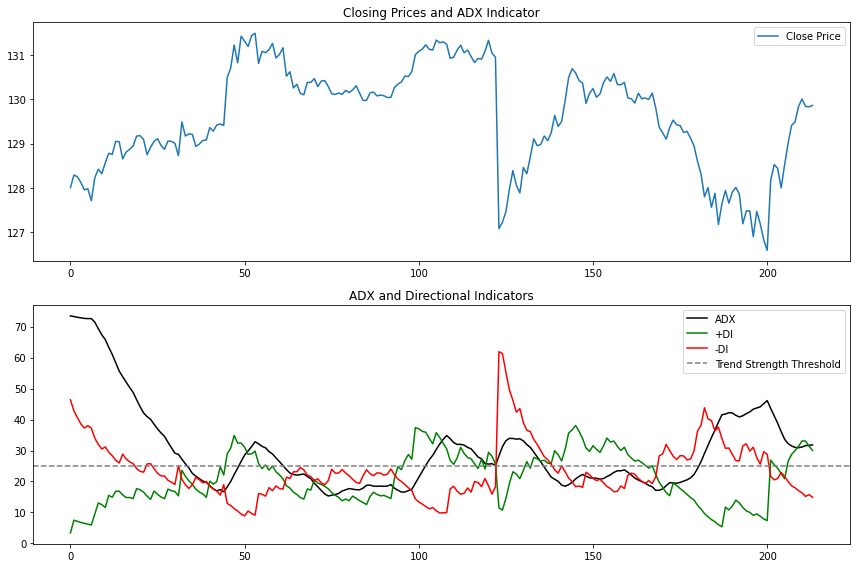

In [7]:
strategy.show_ADX_strat()

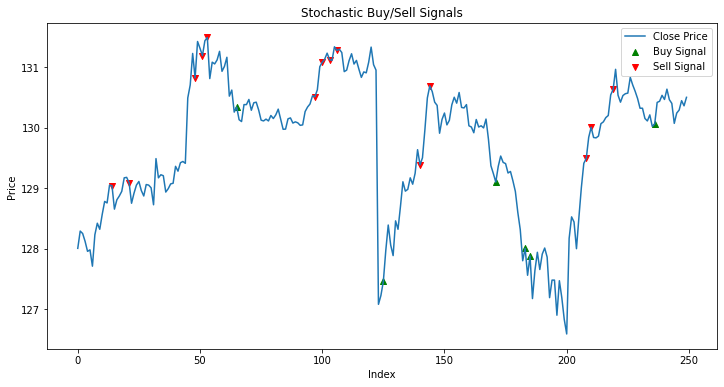

In [8]:
strategy.plot_stochastic_signals()

get best combination (model)

Order #1:
- inicializar declarando la temporalidad elegida
- probar todas las combinaciones
- graficar el resultado de la mejor
- optimizar los parametros de los mejores indicadores, asi como el take_profit, stop_loss y number of shares
- graficar resultados de mejor combinacion optimizada
- graficar mejor combinacion optimizada en test data con la misma temporalidad

In [1]:
from technical_analysis import Operation, TradingStrategy
strategy = TradingStrategy('5m')
strategy.run_combinations()

Ejecutando con combinación de indicadores: ['RSI']
Ejecutando con combinación de indicadores: ['SMA']
Ejecutando con combinación de indicadores: ['MACD']
Ejecutando con combinación de indicadores: ['SAR']
Ejecutando con combinación de indicadores: ['ADX']
Ejecutando con combinación de indicadores: ['Stoch']
Ejecutando con combinación de indicadores: ['RSI', 'SMA']
Ejecutando con combinación de indicadores: ['RSI', 'MACD']
Ejecutando con combinación de indicadores: ['RSI', 'SAR']
Ejecutando con combinación de indicadores: ['RSI', 'ADX']
Ejecutando con combinación de indicadores: ['RSI', 'Stoch']
Ejecutando con combinación de indicadores: ['SMA', 'MACD']
Ejecutando con combinación de indicadores: ['SMA', 'SAR']
Ejecutando con combinación de indicadores: ['SMA', 'ADX']
Ejecutando con combinación de indicadores: ['SMA', 'Stoch']
Ejecutando con combinación de indicadores: ['MACD', 'SAR']
Ejecutando con combinación de indicadores: ['MACD', 'ADX']
Ejecutando con combinación de indicadores: ['

show best model backtesting

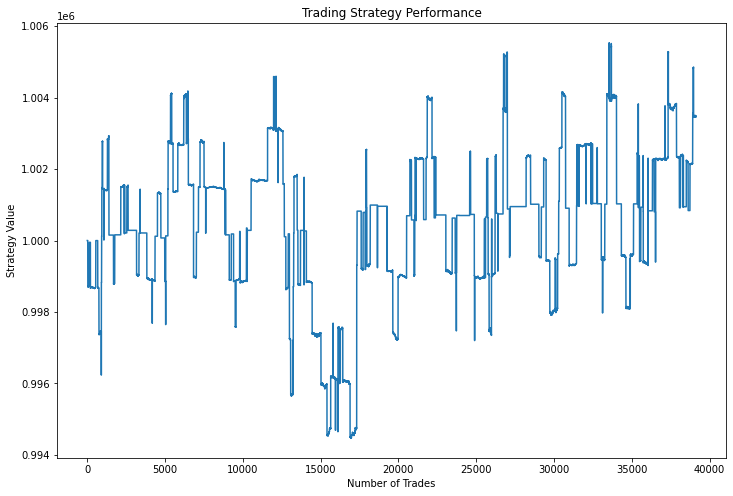

In [2]:
strategy.plot_results(best = True)

best model without optimization on test

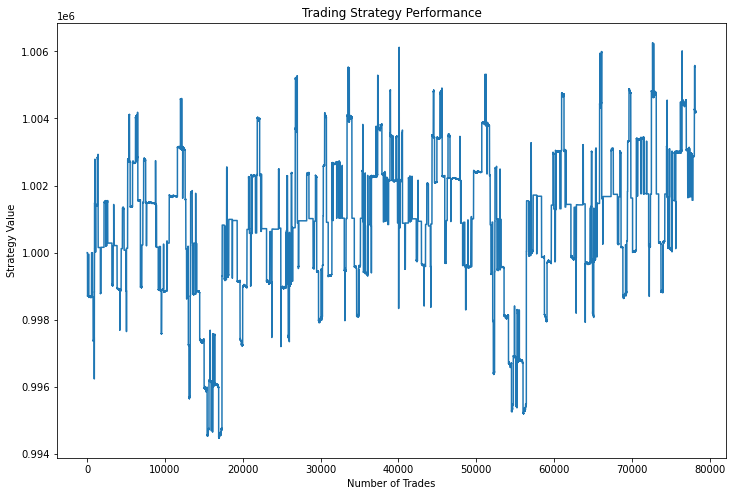

In [3]:
strategy.test()

In [4]:
strategy.strategy_value[-1]

1004180.2180573121

optimize parameters

In [5]:
strategy.optimize_parameters()

[I 2024-02-25 17:14:35,331] A new study created in memory with name: no-name-f80b8912-2be4-4254-ad34-f0df4f33b2d8
[I 2024-02-25 17:15:29,183] Trial 0 finished with value: 1005826.5345914057 and parameters: {'sar_step': 0.06797549593627028, 'sar_max_step': 0.2190743113468926, 'adx_window': 18, 'take_profit': 1.0929134413844337, 'stop_loss': 0.9161050958191587, 'n_shares': 62}. Best is trial 0 with value: 1005826.5345914057.
[I 2024-02-25 17:16:22,413] Trial 1 finished with value: 1022082.8432980159 and parameters: {'sar_step': 0.05149662110734552, 'sar_max_step': 0.2929052299837034, 'adx_window': 10, 'take_profit': 1.0288167378079163, 'stop_loss': 0.8994365561733658, 'n_shares': 188}. Best is trial 1 with value: 1022082.8432980159.
[I 2024-02-25 17:17:10,094] Trial 2 finished with value: 999502.3708585417 and parameters: {'sar_step': 0.02548076586086863, 'sar_max_step': 0.18321523792043895, 'adx_window': 17, 'take_profit': 1.1144450547140128, 'stop_loss': 0.8210441334333176, 'n_shares':

Mejores parámetros encontrados: {'sar_step': 0.05149662110734552, 'sar_max_step': 0.2929052299837034, 'adx_window': 10, 'take_profit': 1.0288167378079163, 'stop_loss': 0.8994365561733658, 'n_shares': 188}


show strategy backtest with optimizedd paramters

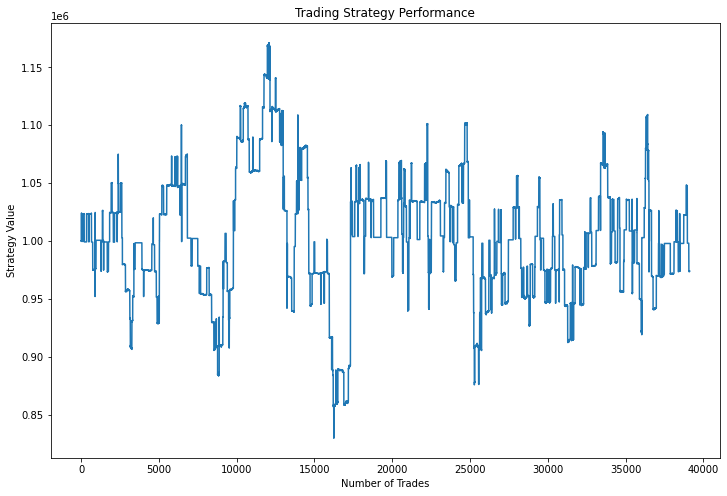

In [6]:
strategy.plot_results(best = True)

final value best optimized strat

In [7]:
strategy.strategy_value[-1]

973932.1069086604

In [8]:
len(strategy.strategy_value)

39128

Run and backtest best strat on test data

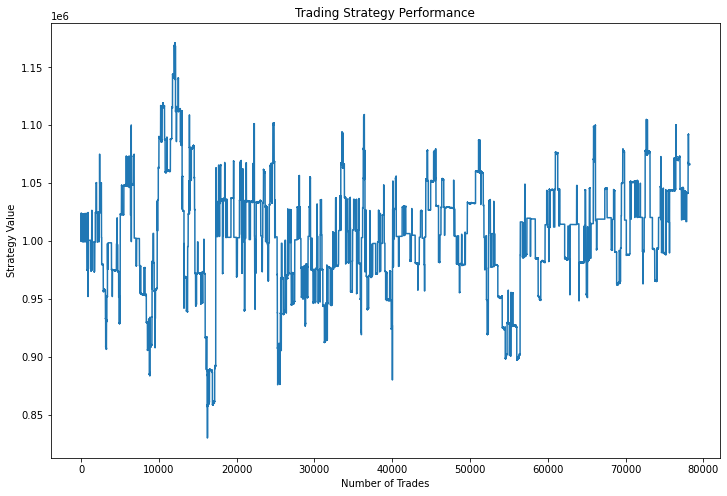

In [9]:
strategy.test()

final value of test

In [10]:
strategy.strategy_value[-1]

1065982.0766351214

---

Order #2:
- inicializar declarando la temporalidad elegida
- manualmente elegir los indicadores seleccionados arbitrariamente por el usuario
- optimizar la estrategia compuesta por los indicadores dados por el usuario

In [1]:
from technical_analysis import Operation, TradingStrategy
strategy = TradingStrategy('5m')

strategy.activate_indicator('RSI')
strategy.activate_indicator('MACD')
strategy.activate_indicator('RSI')

In [2]:
strategy.active_indicators

['RSI', 'MACD', 'RSI']

In [3]:
strategy.optimize_parameters(prior=True)

[I 2024-02-25 17:36:08,032] A new study created in memory with name: no-name-af541825-f641-45bd-a33d-57d5b97cc8d0
[I 2024-02-25 17:37:20,150] Trial 0 finished with value: -2091496.3143869792 and parameters: {'rsi_window': 20, 'macd_fast': 14, 'macd_slow': 39, 'macd_sign': 7, 'take_profit': 1.0243645938959576, 'stop_loss': 0.8470066623347541, 'n_shares': 378}. Best is trial 0 with value: -2091496.3143869792.
[I 2024-02-25 17:39:40,009] Trial 1 finished with value: -1178267.539976055 and parameters: {'rsi_window': 7, 'macd_fast': 16, 'macd_slow': 22, 'macd_sign': 13, 'take_profit': 1.1533130859850893, 'stop_loss': 0.844905964032438, 'n_shares': 175}. Best is trial 1 with value: -1178267.539976055.
[I 2024-02-25 17:41:22,017] Trial 2 finished with value: -437836.86174984457 and parameters: {'rsi_window': 13, 'macd_fast': 20, 'macd_slow': 29, 'macd_sign': 5, 'take_profit': 1.0670787200887057, 'stop_loss': 0.864223941701792, 'n_shares': 131}. Best is trial 2 with value: -437836.86174984457.

Mejores parámetros encontrados: {'rsi_window': 13, 'macd_fast': 20, 'macd_slow': 29, 'macd_sign': 5, 'take_profit': 1.0670787200887057, 'stop_loss': 0.864223941701792, 'n_shares': 131}


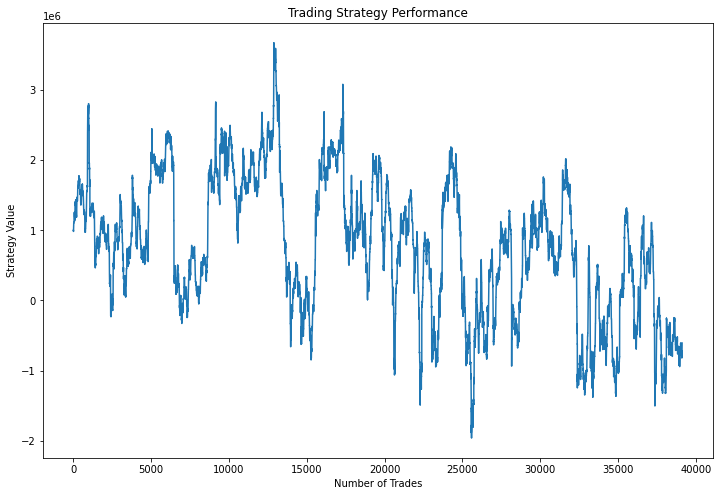

In [4]:
strategy.plot_results()

In [ ]:
strategy.test()